In [1]:
import torch
from torch import nn
import torchvision
import numpy as np
import os
from torchsummary import summary
from PIL import Image
from torchvision import transforms
from tqdm import tqdm
import sys

sys.path.append("/workspaces/ood/")

from torch.utils.data import DataLoader
from ood.data import EmbDataset
from ood.model import LinearClass
from ood.train import train
from ood.eval import accuracy

%load_ext autoreload
%autoreload 2


device = torch.device("cuda")

torch.cuda.is_available()

True

# Cross Entropy ImageNet pretrain

### 1) Load data

In [2]:
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
transform = transforms.Compose(
    [
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        normalize,
    ]
)

In [3]:
cifar_data_train = torchvision.datasets.CIFAR10(
    "../data/cifar10", download=False, transform=transform
)
cifar_data_test = torchvision.datasets.CIFAR10(
    "../data/cifar10", download=False, transform=transform, train=False
)

svhn_data_train = torchvision.datasets.SVHN(
    "../data/svhn", download=False, transform=transform
)
svhn_data_test = torchvision.datasets.SVHN(
    "../data/svhn", download=False, transform=transform, split="test"
)

### 2) Load model

In [4]:
soft_model = torchvision.models.resnet50(pretrained=False)
soft_model.load_state_dict(
    torch.load(
        "/workspaces/ood/data/models/torch/hub/checkpoints/resnet50-0676ba61.pth"
    )
)
soft_model.to(device)
soft_model.eval();

### 3) Make sanity check prediction

In [5]:
names = []
with open("/workspaces/ood/data/imagenet1000_clsidx_to_labels.txt") as fd:
    for line in fd:
        name = line[line.find(" ") :][1:-2]
        names.append(name)

cat = Image.open("/workspaces/ood/data/test_samples/cat.jpg")
cat = cat.convert("RGB")
pred = (
    soft_model(torch.unsqueeze(transform(cat).to(device), dim=0)).cpu().detach().numpy()
)
a = np.argsort(pred[0])[::-1]
print([names[x] for x in a[:10]])

/opt/conda/lib/python3.8/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ../c10/core/TensorImpl.h:1153.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


["282: 'tiger cat'", "281: 'tabby, tabby cat',model_pre", "285: 'Egyptian cat'", "292: 'tiger, Panthera tigris'", "287: 'lynx, catamount'", "728: 'plastic bag'", "753: 'radiator'", "288: 'leopard, Panthera pardus'", "852: 'bucket, pail'", "290: 'jaguar, panther, Panthera onca, Felis onca'"]


### 4) Predict on whole datasets

In [6]:
# from ood.utils import add_labels, predict_on_whole_dataset
# predict_on_whole_dataset(soft_model, cifar_data_train, 'soft_cifar_train')

# #add labels to file along with emb
# cifar_data_train = torchvision.datasets.CIFAR10('../data/cifar10', download=False)
# add_labels(cifar_data_train, 'soft_cifar_train')

### 5) Train linear classification model on soft embeddings of Cifar 10

In [7]:
# from torch.optim.lr_scheduler import StepLR

# cifar_train = EmbDataset('../data/predictions/soft_cifar_train.npy', emb_size=1000)
# cifar_test = EmbDataset('../data/predictions/soft_cifar_test.npy', emb_size=1000)

# soft_cifar_linear_model = LinearClass(emb_size=1000, num_classes=10).to(device)

# criterion = nn.CrossEntropyLoss()
# optimizer = torch.optim.Adam(soft_cifar_linear_model.parameters(), lr=1e-4, weight_decay=1e-6)
# scheduler = StepLR(optimizer, step_size=20, gamma=0.5)

# cifar_train_dataloader = DataLoader(cifar_train, batch_size=256, shuffle=True)
# cifar_test_dataloader = DataLoader(cifar_test, batch_size=256, shuffle=False)

# train(cifar_train_dataloader, cifar_test_dataloader,
#     soft_cifar_linear_model, optimizer, scheduler,
#     criterion, accuracy,
#     train_epoch=140, metric_freq=1500, device=device)

In [8]:
# torch.save(soft_cifar_linear_model.state_dict(), f'../data/trained_models/soft_cifar_linear_model0.88test_accuracy.pth')

### 6) Perform out of distribution detection

#### a) Softmax ood
Here we take maximun softmax score and compare it to threshold **t**.

In [9]:
from ood.eval import evaluate_linearmodel

model = LinearClass(emb_size=1000, num_classes=10)
model.load_state_dict(
    torch.load("../data/trained_models/soft_cifar_linear_model0.88test_accuracy.pth")
)
model.eval().to(device)

cifar_test = EmbDataset("../data/predictions/soft_cifar_test.npy", emb_size=1000)
svhn_test = EmbDataset("../data/predictions/soft_svhn_test.npy", emb_size=1000)

max_softmax_values_cifar, argmax_softmax_values_cifar = evaluate_linearmodel(
    model, cifar_test, device
)
max_softmax_values_svhn, argmax_softmax_values_svhn = evaluate_linearmodel(
    model, svhn_test, device
)

soft_data_to_vis = {"cifar": max_softmax_values_cifar, "svhn": max_softmax_values_svhn}

100%|██████████| 26032/26032 [00:04<00:00, 5224.70it/s]


/opt/conda/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/conda/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


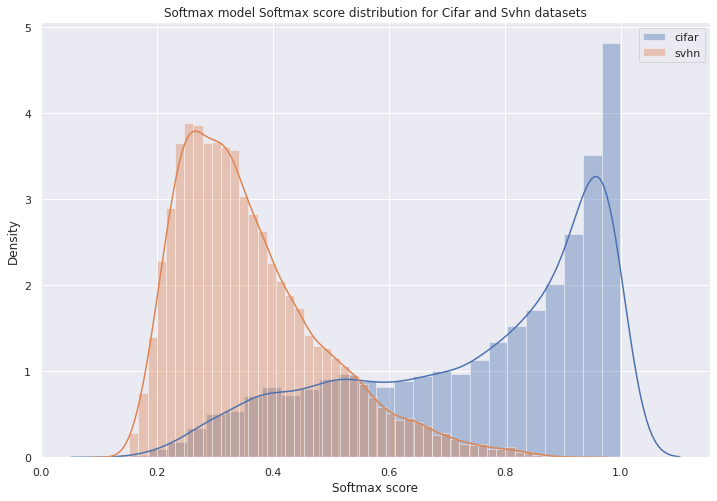

In [30]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme()
plt.figure(figsize=(12, 8))
sns.distplot(
    soft_data_to_vis["cifar"], kde=True, norm_hist=True, hist=True, label="cifar"
)
sns.distplot(
    soft_data_to_vis["svhn"], kde=True, norm_hist=True, hist=True, label="svhn"
)

plt.title("Softmax model Softmax score distribution for Cifar and Svhn datasets")
plt.xlabel("Softmax score")

plt.legend();

#### б) Energy ood

In [11]:
from ood.eval import compute_energy

model = LinearClass(emb_size=1000, num_classes=10)
model.load_state_dict(
    torch.load("../data/trained_models/soft_cifar_linear_model0.88test_accuracy.pth")
)
model.eval().to(device)

cifar_test = EmbDataset("../data/predictions/soft_cifar_test.npy", emb_size=1000)
svhn_test = EmbDataset("../data/predictions/soft_svhn_test.npy", emb_size=1000)

energy_values_cifar = compute_energy(model, cifar_test, device)
energy_values_svhn = compute_energy(model, svhn_test, device)

soft_data_to_vis_energy = {"cifar": -energy_values_cifar, "svhn": -energy_values_svhn}

100%|██████████| 26032/26032 [00:05<00:00, 4722.08it/s]


/opt/conda/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/conda/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


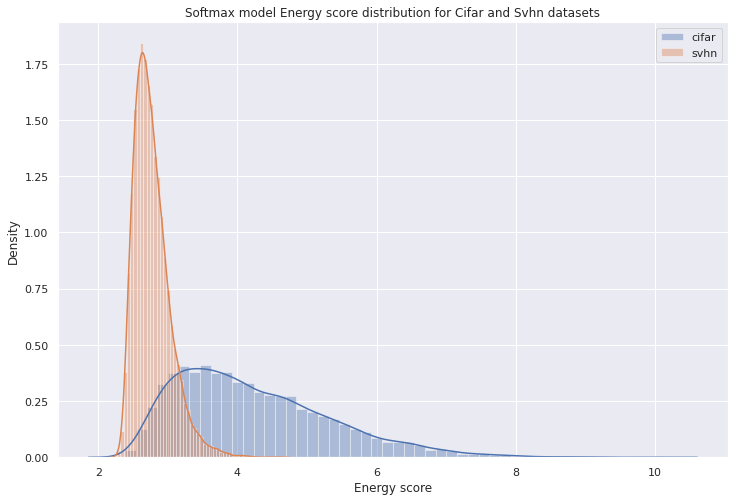

In [31]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme()
plt.figure(figsize=(12, 8))
sns.distplot(
    soft_data_to_vis_energy["cifar"], kde=True, norm_hist=True, hist=True, label="cifar"
)
sns.distplot(
    soft_data_to_vis_energy["svhn"], kde=True, norm_hist=True, hist=True, label="svhn"
)

plt.title("Softmax model Energy score distribution for Cifar and Svhn datasets")
plt.xlabel("Energy score")


plt.legend();

# MoCo v2 ImageNet pretrain

### 1) Load model

In [13]:
# from ood.utils import load_moco

# model = load_moco('/workspaces/ood/data/models/moco_v2_800ep_pretrain.pth.tar', device)

### 2) Predict on whole datasets

In [14]:
# from ood.utils import add_labels, predict_on_whole_dataset_moco

# predict_on_whole_dataset_moco(model, cifar_data_test, 'moco_cifar_test', device)
# predict_on_whole_dataset_moco(model, cifar_data_train, 'moco_cifar_train', device)
# predict_on_whole_dataset_moco(model, svhn_data_train, 'moco_svhn_train', device)
# predict_on_whole_dataset_moco(model, svhn_data_test, 'moco_svhn_test', device)

### 3) Train linear classification model on soft embeddings of Cifar 10

In [15]:
# from torch.optim.lr_scheduler import StepLR

# cifar_train = EmbDataset('../data/predictions/moco_cifar_train.npy', emb_size=2048)
# cifar_test = EmbDataset('../data/predictions/moco_cifar_test.npy', emb_size=2048)

# soft_cifar_linear_model = LinearClass(emb_size=2048, num_classes=10).to(device)

# criterion = nn.CrossEntropyLoss()
# optimizer = torch.optim.Adam(soft_cifar_linear_model.parameters(), lr=1e-4, weight_decay=1e-6)


# scheduler = StepLR(optimizer, step_size=20, gamma=0.5)
# cifar_train_dataloader = DataLoader(cifar_train, batch_size=512, shuffle=True)
# cifar_test_dataloader = DataLoader(cifar_test, batch_size=512, shuffle=False)

# train(cifar_train_dataloader, cifar_test_dataloader,
#     soft_cifar_linear_model, optimizer, scheduler,
#     criterion, accuracy,
#     train_epoch=250, metric_freq=10000, device=device)

In [16]:
# torch.save(soft_cifar_linear_model.state_dict(), f'../data/trained_models/moco_cifar_linear_model0.8382test_accuracy.pth')

### 4) Perform out of distribution detection

#### a) Softmax ood
Here we take maximun softmax score and compare it to threshold **t**.

In [17]:
from ood.eval import evaluate_linearmodel

model = LinearClass(emb_size=2048, num_classes=10)
model.load_state_dict(
    torch.load("../data/trained_models/moco_cifar_linear_model0.8382test_accuracy.pth")
)
model.eval().to(device)

cifar_test = EmbDataset("../data/predictions/moco_cifar_test.npy", emb_size=2048)
svhn_test = EmbDataset("../data/predictions/moco_svhn_test.npy", emb_size=2048)

max_softmax_values_cifar, argmax_softmax_values_cifar = evaluate_linearmodel(
    model, cifar_test, device
)
max_softmax_values_svhn, argmax_softmax_values_svhn = evaluate_linearmodel(
    model, svhn_test, device
)

moco_data_to_vis = {"cifar": max_softmax_values_cifar, "svhn": max_softmax_values_svhn}

100%|██████████| 26032/26032 [00:05<00:00, 4967.06it/s]


/opt/conda/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/conda/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


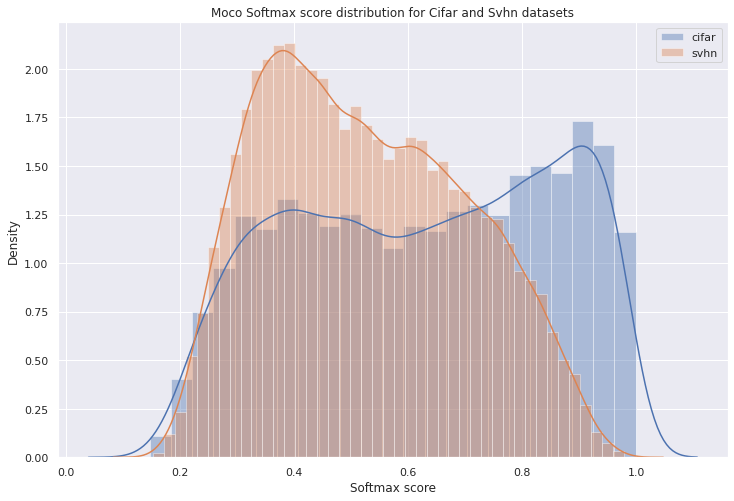

In [29]:
plt.figure(figsize=(12, 8))
sns.distplot(
    moco_data_to_vis["cifar"], kde=True, norm_hist=True, hist=True, label="cifar"
)
sns.distplot(
    moco_data_to_vis["svhn"], kde=True, norm_hist=True, hist=True, label="svhn"
)

plt.title("Moco Softmax score distribution for Cifar and Svhn datasets")
plt.xlabel("Softmax score")

plt.legend();

#### б) Energy ood

In [19]:
from ood.eval import compute_energy

emb_size = 2048
model = LinearClass(emb_size=emb_size, num_classes=10)
model.load_state_dict(
    torch.load("../data/trained_models/moco_cifar_linear_model0.8382test_accuracy.pth")
)
model.eval().to(device)

cifar_test = EmbDataset("../data/predictions/moco_cifar_test.npy", emb_size=emb_size)
svhn_test = EmbDataset("../data/predictions/moco_svhn_test.npy", emb_size=emb_size)

energy_values_cifar = compute_energy(model, cifar_test, device)
energy_values_svhn = compute_energy(model, svhn_test, device)

moco_data_to_vis_energy = {"cifar": -energy_values_cifar, "svhn": -energy_values_svhn}

100%|██████████| 26032/26032 [00:05<00:00, 5047.84it/s]


/opt/conda/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/conda/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


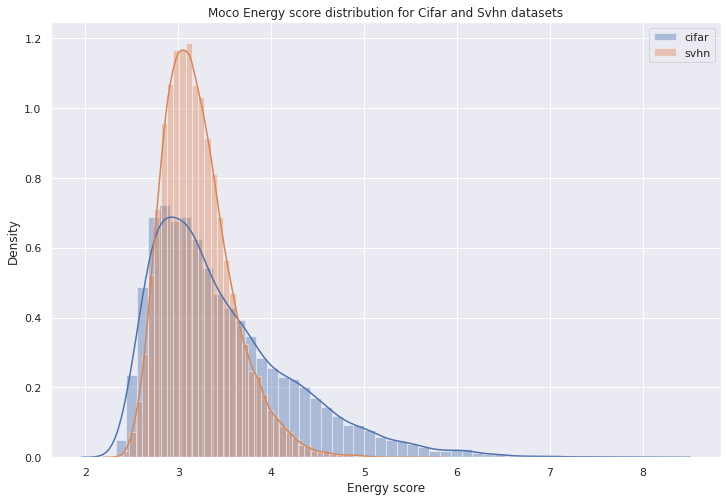

In [28]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8))
sns.distplot(
    moco_data_to_vis_energy["cifar"], kde=True, norm_hist=True, hist=True, label="cifar"
)
sns.distplot(
    moco_data_to_vis_energy["svhn"], kde=True, norm_hist=True, hist=True, label="svhn"
)

plt.title("Moco Energy score distribution for Cifar and Svhn datasets")
plt.xlabel("Energy score")
plt.legend();

# Compute metrics

In [21]:
from ood.ood_metrics import get_measures

auroc, aupr, fpr = get_measures(soft_data_to_vis["cifar"], soft_data_to_vis["svhn"])

In [24]:
from ood.eval import get_ood_metrics_value_range

fractions = np.linspace(0.1, 1, 10)
soft_fprs_softscore, soft_aurocs_soft, soft_auprs_soft = get_ood_metrics_value_range(
    soft_data_to_vis["cifar"], soft_data_to_vis["svhn"], fractions
)

(
    soft_fprs_energyscore,
    soft_aurocs_energyscore,
    soft_auprs_energyscore,
) = get_ood_metrics_value_range(
    soft_data_to_vis_energy["cifar"], soft_data_to_vis_energy["svhn"], fractions
)

moco_fprs_softscore, moco_aurocs_soft, moco_auprs_soft = get_ood_metrics_value_range(
    moco_data_to_vis["cifar"], moco_data_to_vis["svhn"], fractions
)

(
    moco_fprs_energyscore,
    moco_aurocs_energyscore,
    moco_auprs_energyscore,
) = get_ood_metrics_value_range(
    moco_data_to_vis_energy["cifar"], moco_data_to_vis_energy["svhn"], fractions
)

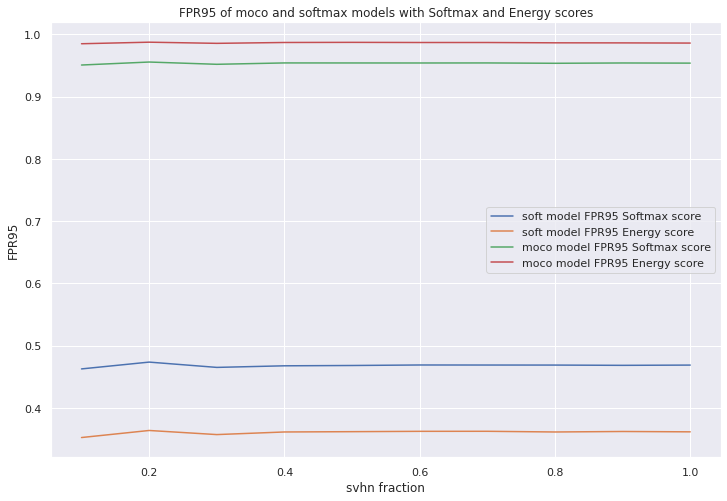

In [27]:
import matplotlib.pyplot as plt


plt.figure(figsize=(12, 8))
plt.plot(fractions, soft_fprs_softscore, label="soft model FPR95 Softmax score")
plt.plot(fractions, soft_fprs_energyscore, label="soft model FPR95 Energy score")

plt.plot(fractions, moco_fprs_softscore, label="moco model FPR95 Softmax score")
plt.plot(fractions, moco_fprs_energyscore, label="moco model FPR95 Energy score")

plt.title("FPR95 of moco and softmax models with Softmax and Energy scores")
plt.xlabel("svhn fraction")
plt.ylabel("FPR95")
plt.legend()